# Desmascarando Robôs
### CRISP-DM Cycle 1
---

Imagine um mercado online, um palco digital onde diversos leilões se desenrolam a cada segundo. Neste ambiente, participantes do mundo inteiram lançam seus lances em busca de objetos desejados, desde joias até equipamentos tecnológicos. No entanto, nem todos os jogadores neste campo são humanos; alguns são robôs programados para manipular os resultados dos leilões.

Seu desafio é se aprofundar nesses dados, explorar as camadas de atividade nos leilões e conseguir construir um modelo que saiba muito bem diferenciar humanos de robôs.

> Disclaimer: This is a fictional bussiness cas

## 0. PREPARATION

### 0.1 Settings

In [1]:
# Settings imports
import os
import sys
import numpy as np
import pandas as pd
from dotenv import load_dotenv

# Load .env file
env_path = "../.env"
load_dotenv(dotenv_path=env_path)

# Seed
seed = int(os.getenv("SEED"))

# Add path
path = os.getenv("HOMEPATH")

# Add path to sys.path
sys.path.append(path)

In [2]:
from catboost import CatBoostClassifier

In [3]:
from helper.classes.Pipeline import MLPipeline
from helper.classes.Predictions import Predictions
from helper.classes.CatBoostOptunaPipeline import CatBoostOptunaPipeline

/Users/guttofranca/Repos/desmascarando-robos/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.2 Data

**Train e Test**

- **id_participante**: Identificador único do participante
- **conta_pagamento**: Conta de pagamento associada ao participante (com o valor ocultado) # Não será utilizada
- **endereco**: Endereço postal do participante # Não será utilizada
- **resultado**: A variável alvo que identifica se o participante é um robô ou um humano. (Robô = 1 e Humano = 0). (*target*)

- **Robôs Confirmados**: Participantes com provas claras de atividades fraudulentas, resultando em banimento da plataforma. São rotulados como robôs no conjunto de dados (resultado = 1).

- **Robôs Suspeitos**: Participantes com atividades atípicas ou estatísticas que superam a média, mas sem provas definitivas de fraude. A classificação deles como robôs é incerta.

**Lances**

- **id_lance**: Identificador único do lance
- **id_participante**: Identificador único do participante
- **leilao**: Identificador único do leilão 
- **mercadoria**: A categoria da mercadoria leiloada
- **dispositivo**: O dispositivo utilizado pelo visitante
- **tempo**: O tempo que o lance foi feito
- **pais**: O país que o IP pertence
- **ip**: O IP do participante
- **url**: A URL de onde o participante foi referido

## 1. Modelling

### 1.1 Loading Data

In [4]:
X_train = pd.read_feather(path + "/data/processed/X_train.feather")
X_test = pd.read_feather(path + "/data/processed/X_test.feather")
X_val = pd.read_feather(path + "/data/processed/X_val.feather")


y_train = pd.read_pickle(path + "/data/processed/y_train.pkl")
y_test = pd.read_pickle(path + "/data/processed/y_test.pkl")
y_val = pd.read_pickle(path + "/data/processed/y_val.pkl")

for data in [X_train, X_test, X_val]:
    data.drop(
        columns=[
            "pais",
            "url",
            "endereco",
            "dispositivo",
            "leilao",
            "periodo_dia",
            "mercadoria",
            "conta_pagamento",
        ],
        inplace=True,
    )

In [5]:
feature_transformations = {
    "log": [
        "contagem_participante",
        "contagem_leilao",
        "contagem_conta_pagamento",
        "frequencia_dispositivo",
    ],
    # "one_hot": [
    #    "dispositivo",
    #    "leilao",
    #    "periodo_dia",
    #    "mercadoria",
    #    "conta_pagamento",
    # ],
    "ordinal": ["ip_classe"],
    # "hashing": ["pais", "url", "endereco"],
    "min_max_scaler": [
        "hora_sin",
        "hora_cos",
        "minuto_sin",
        "minuto_cos",
        "segundo_sin",
        "segundo_cos",
    ],
    "robust_scaler": ["hora", "minuto", "segundo"],
}

In [6]:
proportion = float(len(y_train[y_train == 0])) / len(y_train[y_train == 1])

models = [
    CatBoostClassifier(scale_pos_weight=proportion, random_state=seed, verbose=0),
]

Starting run...
Starting fit_transform...
Transformers configured.
ColumnTransformer created.
fit_transform completed.
Data transformation completed.
Training model CatBoostClassifier...
Finding best threshold for model CatBoostClassifier...
Best threshold for model CatBoostClassifier found: 0.4
Evaluating model CatBoostClassifier...
Evaluation completed for model CatBoostClassifier.
Model CatBoostClassifier trained and evaluated.
Plotting confusion matrix for model CatBoostClassifier...


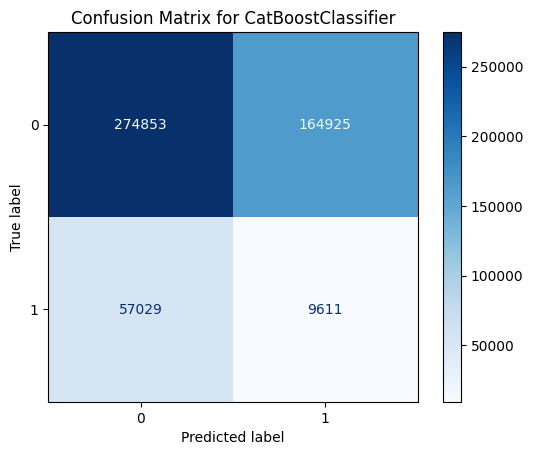

Run completed.


,model,brier_score_loss,log_loss,f1_score,recall,precision,roc_auc,balanced_accuracy,best_threshold
0,CatBoostClassifier,0.429828,3.056711,0.079701,0.144223,0.055066,0.408109,0.384602,0.4


In [7]:
pipeline = MLPipeline(feature_transformations, models)
results = pipeline.run(X_train, y_train, X_test, y_test)
results

Starting cross-validation run...
Processing fold 1/5...
Starting fit_transform...
Transformers configured.
ColumnTransformer created.
fit_transform completed.
Data transformation completed.
Training model CatBoostClassifier on fold 1...
Finding best threshold for model CatBoostClassifier...
Best threshold for model CatBoostClassifier found: 0.6000000000000002
Evaluating model CatBoostClassifier...
Evaluation completed for model CatBoostClassifier.
Model CatBoostClassifier trained and evaluated on fold 1.
Plotting confusion matrix for model CatBoostClassifier...


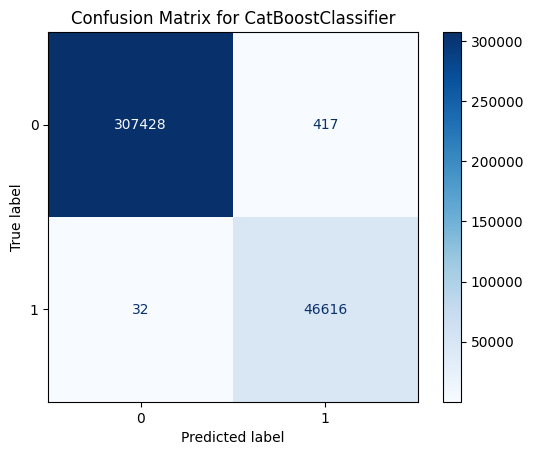

Processing fold 2/5...
Starting fit_transform...
Transformers configured.
ColumnTransformer created.
fit_transform completed.
Data transformation completed.
Training model CatBoostClassifier on fold 2...
Finding best threshold for model CatBoostClassifier...
Best threshold for model CatBoostClassifier found: 0.6000000000000002
Evaluating model CatBoostClassifier...
Evaluation completed for model CatBoostClassifier.
Model CatBoostClassifier trained and evaluated on fold 2.
Plotting confusion matrix for model CatBoostClassifier...


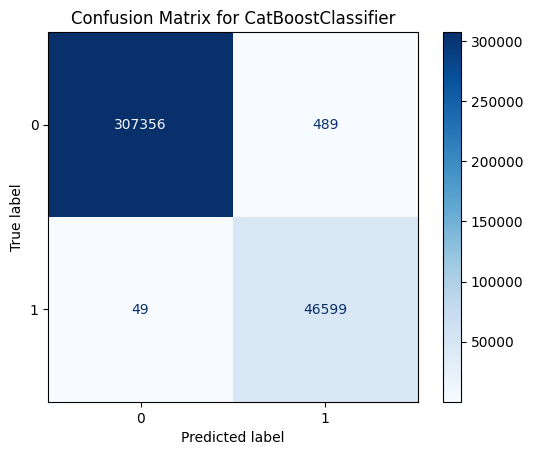

Processing fold 3/5...
Starting fit_transform...
Transformers configured.
ColumnTransformer created.
fit_transform completed.
Data transformation completed.
Training model CatBoostClassifier on fold 3...
Finding best threshold for model CatBoostClassifier...
Best threshold for model CatBoostClassifier found: 0.6000000000000002
Evaluating model CatBoostClassifier...
Evaluation completed for model CatBoostClassifier.
Model CatBoostClassifier trained and evaluated on fold 3.
Plotting confusion matrix for model CatBoostClassifier...


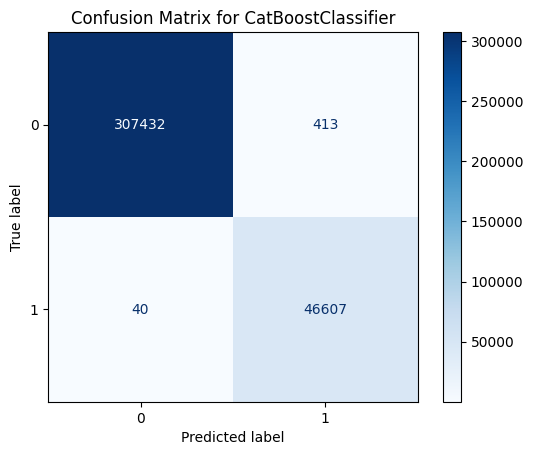

Processing fold 4/5...
Starting fit_transform...
Transformers configured.
ColumnTransformer created.
fit_transform completed.
Data transformation completed.
Training model CatBoostClassifier on fold 4...
Finding best threshold for model CatBoostClassifier...
Best threshold for model CatBoostClassifier found: 0.6000000000000002
Evaluating model CatBoostClassifier...
Evaluation completed for model CatBoostClassifier.
Model CatBoostClassifier trained and evaluated on fold 4.
Plotting confusion matrix for model CatBoostClassifier...


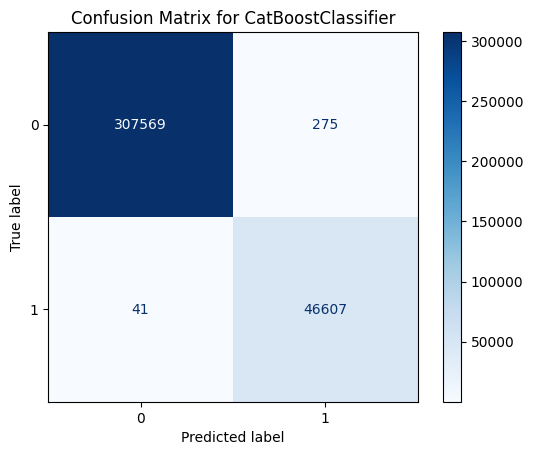

Processing fold 5/5...
Starting fit_transform...
Transformers configured.
ColumnTransformer created.
fit_transform completed.
Data transformation completed.
Training model CatBoostClassifier on fold 5...
Finding best threshold for model CatBoostClassifier...
Best threshold for model CatBoostClassifier found: 0.6000000000000002
Evaluating model CatBoostClassifier...
Evaluation completed for model CatBoostClassifier.
Model CatBoostClassifier trained and evaluated on fold 5.
Plotting confusion matrix for model CatBoostClassifier...


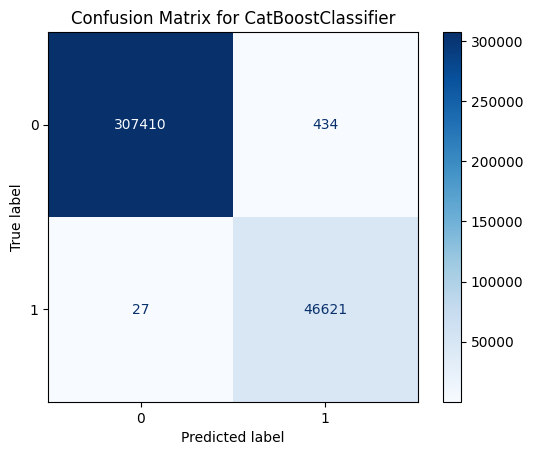

Cross-validation run completed.


,model,brier_score_loss,log_loss,f1_score,recall,precision,roc_auc,balanced_accuracy,fold,best_threshold
0,CatBoostClassifier,0.001096,0.004802,0.995207,0.999314,0.991134,0.999994,0.998980,1,0.6
1,CatBoostClassifier,0.001317,0.005503,0.994260,0.998950,0.989615,0.999988,0.998681,2,0.6
2,CatBoostClassifier,0.001107,0.004463,0.995164,0.999142,0.991217,0.999994,0.998900,3,0.6
3,CatBoostClassifier,0.000805,0.003566,0.996621,0.999121,0.994134,0.999996,0.999114,4,0.6
4,CatBoostClassifier,0.001108,0.004614,0.995080,0.999421,0.990777,0.999994,0.999006,5,0.6


In [8]:
results_cv, metrics_cv = pipeline.run_cv(X_train, y_train)
results_cv

### Optuna

In [9]:
optuna_pipeline = CatBoostOptunaPipeline(feature_transformations, n_trials=50)

In [10]:
results_optuna, best_params = optuna_pipeline.run(X_train, y_train, X_val, y_val)

[I 2024-06-15 22:14:09,629] A new study created in memory with name: no-name-52d0fe12-b564-4155-8180-1b3b52edd93d
[I 2024-06-15 22:14:45,248] Trial 0 finished with value: 0.1379602972626546 and parameters: {'iterations': 419, 'depth': 4, 'learning_rate': 0.0014310048076660443, 'random_strength': 0.022070624309920163, 'bagging_temperature': 0.8042341281707596, 'border_count': 30}. Best is trial 0 with value: 0.1379602972626546.
[I 2024-06-15 22:15:46,580] Trial 1 finished with value: 0.16874585314922763 and parameters: {'iterations': 609, 'depth': 7, 'learning_rate': 0.018921826639846033, 'random_strength': 0.001690859425575059, 'bagging_temperature': 0.1578866396086277, 'border_count': 231}. Best is trial 0 with value: 0.1379602972626546.
[I 2024-06-15 22:16:37,016] Trial 2 finished with value: 0.14376357052781616 and parameters: {'iterations': 584, 'depth': 4, 'learning_rate': 0.007455553999314851, 'random_strength': 0.1641328421039454, 'bagging_temperature': 0.9506629064099542, 'bord

0:	learn: 0.6900221	total: 115ms	remaining: 1m 44s
1:	learn: 0.6869303	total: 227ms	remaining: 1m 42s
2:	learn: 0.6838703	total: 339ms	remaining: 1m 41s
3:	learn: 0.6808409	total: 461ms	remaining: 1m 43s
4:	learn: 0.6778430	total: 585ms	remaining: 1m 45s
5:	learn: 0.6749142	total: 704ms	remaining: 1m 45s
6:	learn: 0.6719767	total: 827ms	remaining: 1m 46s
7:	learn: 0.6690693	total: 942ms	remaining: 1m 45s
8:	learn: 0.6661921	total: 1.06s	remaining: 1m 45s
9:	learn: 0.6633440	total: 1.18s	remaining: 1m 45s
10:	learn: 0.6605256	total: 1.3s	remaining: 1m 45s
11:	learn: 0.6577387	total: 1.43s	remaining: 1m 46s
12:	learn: 0.6549782	total: 1.56s	remaining: 1m 46s
13:	learn: 0.6522458	total: 1.67s	remaining: 1m 46s
14:	learn: 0.6495418	total: 1.78s	remaining: 1m 45s
15:	learn: 0.6468359	total: 1.95s	remaining: 1m 48s
16:	learn: 0.6441879	total: 2.06s	remaining: 1m 47s
17:	learn: 0.6415672	total: 2.18s	remaining: 1m 47s
18:	learn: 0.6389736	total: 2.3s	remaining: 1m 47s
19:	learn: 0.6364068	tot

In [11]:
best_params

{'iterations': 905,
 'depth': 9,
 'learning_rate': 0.0032193578881126797,
 'random_strength': 0.05022200281503645,
 'bagging_temperature': 0.5648259544017337,
 'border_count': 1}

In [13]:
model = CatBoostClassifier(
    iterations=905,
    depth=9,
    learning_rate=0.0032193578881126797,
    random_strength=0.05022200281503645,
    bagging_temperature=0.5648259544017337,
    border_count=1,
    scale_pos_weight=proportion,
    random_state=seed,
    verbose=0,
)

In [14]:
import numpy as np


X = np.concatenate([X_train, X_test, X_val], axis=0)
y = np.concatenate([y_train, y_test, y_val], axis=0)

In [16]:
from helper.classes.Predictions import Predictions

test = pd.read_feather(path + "/data/processed/test.feather")

final_pipeline = Predictions(feature_transformations, model)
final_pipeline.fit(X, y)
test = final_pipeline.add_predictions(test)

Training model CatBoostClassifier...
Starting fit_transform...
Transformers configured.
ColumnTransformer created.


ValueError: Specifying the columns using strings is only supported for dataframes.

In [12]:
# test = pd.read_feather(path + "/data/processed/test.feather")


# test[['id_participante', 'predicao']].to_csv(path + "/data/processed/predicao.csv", index=False)